# THREDDS Server NEXRAD Level II and III Radar 

## Available Data 1 Month out from Current Day

### Currently this notebook only plots 
* Base Reflectivity 
* Radial Velocity
* Many other products available from data - notebook needs updating

<img src="https://s.w-x.co/wsr-88dconuscoverage2011.jpg">

In [ ]:
print("This Notebook only plots: Base Reflectivity and Radial Velocity"+"\n"+
     "Many other products are available in the data!")

In [ ]:
from datetime import datetime, timedelta
import time

import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import patheffects
from matplotlib.colors import LinearSegmentedColormap

import numpy as np

import metpy
from metpy.plots import ctables

import pandas as pd

from siphon.catalog import TDSCatalog
from siphon.cdmr import Dataset
from siphon.radarserver import get_radarserver_datasets, RadarServer

In [ ]:
rad_vel = pd.read_csv("/Users/chowdahead/Documents/radial_velocity_cmap.csv")
rad_vel_colors = []
for i in range(0,256):
    rad_vel_colors.append((float(rad_vel["r"][i]),
                               float(rad_vel["g"][i]),
                               float(rad_vel["b"][i]),
                               float(rad_vel["a"][i])
                             ))
cmap_name="rad_vel"
rad_vel_cmap = LinearSegmentedColormap.from_list(
            cmap_name, rad_vel_colors)

In [ ]:
refl = pd.read_csv("/Users/chowdahead/Documents/refl_cmap.csv")
refl_colors = []
for i in range(0,255):
    refl_colors.append((float(refl["r"][i]),
                               float(refl["g"][i]),
                               float(refl["b"][i]),
                               float(refl["a"][i])
                             ))
cmap_name="refl"
refl_cmap = LinearSegmentedColormap.from_list(
            cmap_name, refl_colors)

In [ ]:
prod_dict = {"N0V":{"prod_name":"Velocity","dataset_name":"RadialVelocity"},
             "N1P":{"prod_name":"Precip1hr","dataset_name":"Precip1hr"},
             "N0Q":{"prod_name":"Reflectivity","dataset_name":"BaseReflectivityDR"},
             "N0S":{"prod_name":"StormMeanVelocity","dataset_name":"StormMeanVelocity"},
             "N0C":{"prod_name":"CC","dataset_name":"CorrelationCoefficient"},
             "N0H":{"prod_name":"HydroClass","dataset_name":"HydrometeorClassification"},
    
}

In [ ]:
available_product_list = ['DAA',
 'DHR',
 'DOD',
 'DPA',
 'DPR',
 'DSD',
 'DSP',
 'DTA',
 'DU3',
 'DU6',
 'DVL',
 'EET',
 'HHC',
 'N0C',
 'N0H',
 'N0K',
 'N0M',
 'N0Q',
 'N0R',
 'N0S',
 'N0U',
 'N0V',
 'N0X',
 'N0Z',
 'N1C',
 'N1H',
 'N1K',
 'N1M',
 'N1P',
 'N1Q',
 'N1S',
 'N1U',
 'N1X',
 'N2C',
 'N2H',
 'N2K',
 'N2M',
 'N2Q',
 'N2S',
 'N2U',
 'N2X',
 'N3C',
 'N3H',
 'N3K',
 'N3M',
 'N3Q',
 'N3S',
 'N3U',
 'N3X',
 'NAC',
 'NAH',
 'NAK',
 'NAM',
 'NAQ',
 'NAU',
 'NAX',
 'NBC',
 'NBH',
 'NBK',
 'NBM',
 'NBQ',
 'NBU',
 'NBX',
 'NCR',
 'NET',
 'NMD',
 'NST',
 'NTP',
 'NVL',
 'NVW',
 'OHA',
 'PTA']

---

In [ ]:
def query_radar_data(data_set,station,product,start,
                     minute_delta=0,hour_delta=0,day_delta=0):
    
    """
    ---------------------
    Query the radar data
    ---------------------
    ** Must run this function first to query and grab data **
    
    Arguments
    ----------
    data_set: name of the the THREDDS Radar Dataset, ie NEXRAD Level III Radar from IDD
    station: coded station name, ie FTG for Denver
    start: dataset start time
    
    Time deltas for range of times for query (default none)
    minute_delta: 
    hour_delta:
    day_delta:
    
    Returns
    -------
    file_list:
    dataset: shortened name of chosen THREDDS dataset 
    LatLonBox: lat/lon extent around radar station
    
    """
    
    end = start+timedelta(days=day_delta, minutes=minute_delta, hours=hour_delta)
    

    print(f"query start time:{start}")
    print(f"query end time:{end}")
    ds = get_radarserver_datasets('http://thredds.ucar.edu/thredds/')
    
    dataset = str(ds[3])[:22]

    url = ds[data_set].follow().catalog_url
    rs = RadarServer(url)
    print(rs.stations[station])

    query = rs.query()
    query.stations(station).time_range(start,end).variables(product)
    catalog = rs.get_catalog(query)

    ds[data_set].follow().catalog_url
    file_list = list(catalog.datasets.values())
    for t in file_list: print(t)
    LatLonBox = [rs.stations[station].longitude-3,rs.stations[station].longitude+3,
                 rs.stations[station].latitude-2,rs.stations[station].latitude+2]
    
    return file_list,dataset,LatLonBox

In [ ]:
def get_radar_data(file_list,index=0):
    
    """
    ---------------
    Grab radar data
    ---------------
    Produce the data and time strings for each index of the file_list
    
    Arguments
    ---------
    file_list: list of queried files (.nids)
    index: index value of file_list
    
    Returns
    -------
    data: full data object with data and metadata
    title_time: time of particular file formatted for the plot title
    file_time: time of particular file formatted for the saved filename
    
    """
    dsv = file_list[index]
    data = Dataset(dsv.access_urls['CdmRemote'])

    radar_time = ((data.time_coverage_start).replace('T',' ')).replace('Z','')
    date_time_obj = datetime.strptime(radar_time, '%Y-%m-%d %H:%M:%S')

    print('Date:', date_time_obj.date())
    print('Time:', date_time_obj.time())
    print('Date-time:', date_time_obj)
    title_time = "{0:%d %b %Y %H%MZ}".format(date_time_obj)
    file_time = "{0:%Y_%m_%d_%H%MZ}".format(date_time_obj)
    print(title_time,file_time)
    print(data)
    return data, title_time, file_time

In [ ]:
def get_prod_name(product):
    
    """
    -----------------
    Grab product name
    -----------------
    Gives name of product used for filename extension as well as 
    product name in THREDDS database for query call
    
    Arguments
    ---------
    product: abbreviated prodcut name ie N0V,N1P,etc
    
    Returns
    -------
    prod_name: product name for filename
    thredds_product: product name for THREDDS query
    """
    prod_name = prod_dict[product]["prod_name"]
    thredds_product = prod_dict[product]["dataset_name"]

    return prod_name,thredds_product

In [ ]:
def get_radar_vars(data,thredds_product):
    
    """
    --------------------
    Grab radar variables
    --------------------
    
    Arguments
    ---------
    data: full data 
    dataset_name: THREDDS dataset product name
    
    Returns
    -------
    
    radar_data: radar values
    x,y: spatial coordiantes for plotting in imshow/pcolormesh since no 
        lat/lon data is available 
    """
    range_data = data.variables['gate'][:]
    azimuth_data = data.variables['azimuth'][:]
    radar_data = data.variables[thredds_product][:]

    x = range_data*np.sin(np.deg2rad(azimuth_data))[:,None]
    y = range_data*np.cos(np.deg2rad(azimuth_data))[:,None]
    
    return radar_data,x,y

In [ ]:
def make_map(data,LatLonBox): 
    """
    -------------------
    Create map instance
    -------------------
    Initiate the map figure, axis, and projection
    
    Arguments
    ---------
    data: full data
    LatLonBox: lat/lon extent around radar station
    
    Returns
    -------
    fig: new figure
    ax: drawing axis
    proj: map/data projection
    """

    proj = ccrs.LambertConformal(central_longitude=data.RadarLongitude,
                                       central_latitude=data.RadarLatitude)

    fig = plt.figure(figsize=(17,11))
    ax = plt.subplot(111,projection=proj)
    
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    reader = shpreader.Reader('/Users/chowdahead/Documents/shapefiles/countyl010g_shp_nt00964/countyl010g.shp')
    counties = list(reader.geometries())
    COUNTIES = cfeature.ShapelyFeature(counties,ccrs.PlateCarree())
    ax.add_feature(COUNTIES, facecolor='none',edgecolor='w')
    # Grab state borders
    state_borders = cfeature.NaturalEarthFeature(
                category='cultural', name='admin_1_states_provinces_lines',
                scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='w', linewidth=1, zorder=3)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', scale='50m',
                                                edgecolor='face',
                                                facecolor=cfeature.COLORS['water'])
    land = cfeature.NaturalEarthFeature('physical', 'land', scale='50m',
                                               edgecolor='face',
                                               facecolor="k")

    ax.add_feature(ocean, zorder=-1)
    ax.add_feature(land, zorder=-1)
    ax.set_facecolor('black')
    
    ax.set_extent(LatLonBox,ccrs.PlateCarree())
    
    return fig,ax,proj

In [ ]:
def make_text_time_right(ax,end,title_time,dataset,
                         color="w",
                       fontsize=12):  
    
    text_time = ax.text(.995, 0.01, 
            f"{dataset} (dbz)"+"\n"+title_time,
            horizontalalignment='right', transform=ax.transAxes,
            color=color, fontsize=fontsize, weight='bold',zorder=15)
    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time.set_path_effects(outline_effect)
    return text_time,ax

def make_text_time_left(ax,station, prod_name,product,
                        color="w",
                       fontsize=12):  
    
    text_time2 = ax.text(0.005, 0.01, 
                "Station: "+station+"\n"+prod_name+" ("+product+")",
                horizontalalignment='left', transform=ax.transAxes,
                color=color, fontsize=fontsize, weight='bold',zorder=15)
    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time2.set_path_effects(outline_effect)
    return text_time2,ax

In [ ]:
def get_product_cbar_args(prod_name,ax,cbar,outline_effect):
    if prod_name == "Reflectivity":
        ticks = np.arange(-20,80,10)
        Y = 23
    if prod_name == "Velocity":
        ticks = [-60,-45,-20,0,20,45,60]    
        Y = -11
        cbar.ax.text(-76, Y, "RF", ha='center', va='center',path_effects=outline_effect,color="w",fontsize=6) #RF
        
    for count,ele in enumerate(ticks,0): 
        cbar.ax.text(ele, Y, ticks[count], ha='center', va='center',path_effects=outline_effect,color="w",fontsize=6)

In [ ]:
def radar_plot(station,save_path,product,start,file_list,dataset,LatLonBox,index=0):
    
    """
    -------------------
    Plot radar data
    -------------------
    Take final arguments and plot the radar data
    
    Arguments
    ---------
    station: coded station name, ie FTG for Denver
    save_path: path for saved image
    product: abbreviated prodcut name ie N0V,N1P,etc
    start: datetime for start of data query
    file_list: list of queried files (.nids)
    dataset: shortened name of chosen THREDDS dataset
    LatLonBox: lat/lon extent around radar station
    index: file_list index number
    
    Returns
    -------
    fig: new figure
    ax: drawing axis
    proj: map/data projection
    """
    
    data, title_time, file_time = get_radar_data(file_list,index)
    
    prod_name,thredds_product = get_prod_name(product)
    
    radar_data,x,y = get_radar_vars(data,thredds_product)
    
    
    if prod_name == "Velocity":
        cmap = rad_vel_cmap
        vmin=-80
        vmax=80
        
    if prod_name == "Reflectivity":
        cmap = refl_cmap
        vmin=-40
        vmax=84.5
        
    fig,ax,proj = make_map(data,LatLonBox)
    
    mesh = ax.pcolormesh(x,y,radar_data,cmap=cmap,vmin=vmin,vmax=vmax,transform=proj)
    #mesh = ax.pcolormesh(x,y,radar_data,cmap=ref_cmap, norm=ref_norm)
    
    cbar = plt.colorbar(mesh, orientation='horizontal')
    posn = ax.get_position()
    outline_effect = [patheffects.withStroke(linewidth=3, foreground='k')]
    cbar.ax.set_position([posn.x0+0.001, posn.y0-0.001,
                            (posn.x1-posn.x0)/2, posn.height])
    #params = {
    #          "xtick.color" : "k",
    #          "ytick.color" : "k",
    #          "font.size" : 10,
    #              }
    #plt.rcParams.update(params)
    
    cbar.set_ticks([])
    cbar.ax.set_xticklabels([])      
        
    get_product_cbar_args(prod_name,ax,cbar,outline_effect)
  
    make_text_time_right(ax,start,title_time,dataset)
    make_text_time_left(ax,station, prod_name,product)
    
    plt.savefig(f"{save_path+station}_RadarL3_{prod_name}thredds_{file_time}.png",bbox_inches="tight",dpi=200)
    #plt.savefig(save_path+station+"_RadarL3_"+prod_name+"_thredds_"+file_time+".png",bbox_inches="tight",dpi=200)
    #plt.close(fig)    
    plt.show()                               

In [ ]:
Year = 2020
Month = 5
Day = 16
Hour = 1
Minute = 0
station = "FTG"
product = 'N0V'
start = datetime(Year,Month,Day,Hour,Minute)
end = datetime(Year,Month,Day,Hour+1,Minute)
save_path = "/Users/chowdahead/Desktop/"

In [ ]:
list(get_radarserver_datasets('http://thredds.ucar.edu/thredds/'))

In [ ]:
file_list,dataset,LatLonBox = query_radar_data('NEXRAD Level III Radar from IDD',station,product,start,
                                          minute_delta=20,hour_delta=1,day_delta=0,Now=False)

In [ ]:
#file_list

In [ ]:
Radar_Product(station,save_path,product,start,file_list,dataset,LatLonBox,index=2)

In [ ]:
for i in range(len(file_list)):
    Radar_Product(station,save_path,product,start,file_list,dataset,LatLonBox,index=i)

In [1]:
cd ~/Downloads/

/Users/chowdahead/Downloads


In [2]:
ls *.py


Thredds_Lev3_Radar.py
Thredds_Lev3_Radar_Functions_2020_script.py


In [5]:
import Thredds_Lev3_Radar as radar

This library only plots Base Reflectivity and Radial Velocity
Many other products are available in the data!

NEXRAD Level II Radar for Case Study CCS039
NEXRAD Level II Radar from IDD
NEXRAD Level III Radar for Case Study CCS039
NEXRAD Level III Radar from IDD
TDWR Level III Radar from IDD
Start by running the query_radar_data function, then the radar_plot fucntion


query start time:2020-05-16 15:44:00.270139
query end time:2020-05-16 15:44:00.270139
Station(id='FTG', elevation=1675.0, latitude=39.78, longitude=-104.53, name='DENVER/BOULDER/Denver')
Level3_FTG_N0V_20200516_1536.nids
Date: 2020-05-16
Time: 15:36:43
Date-time: 2020-05-16 15:36:43
16 May 2020 1536Z 2020_05_16_1536Z
https://thredds.ucar.edu/thredds/cdmremote/nexrad/level3/IDD/N0V/FTG/20200516/Level3_FTG_N0V_20200516_1536.nids
Dimensions:
<class 'siphon.cdmr.dataset.Dimension'> name = azimuth, size = 360
<class 'siphon.cdmr.dataset.Dimension'> name = gate, size = 230
Variables:
<class 'siphon.cdmr.dataset.Variable'>
float32 elevation(azimuth)
	_CoordinateAxisType: RadialElevation
	units: degrees
	long_name: elevation angle in degres: 0 = parallel to pedestal base, 90 = perpendicular
shape = 360
<class 'siphon.cdmr.dataset.Variable'>
float32 azimuth(azimuth)
	_CoordinateAxisType: RadialAzimuth
	units: degrees
	long_name: azimuth angle in degrees: 0 = true north, 90 = east
shape = 360
<c

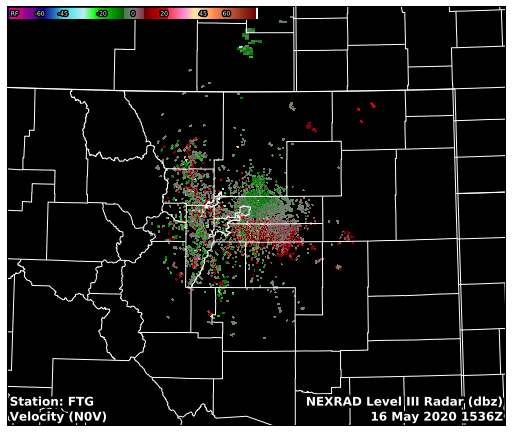

In [6]:
radar.example()

In [7]:
radar.get_prod_name?

In [ ]:
radar.get_prod_name("N0Q")